In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"qifangu","key":"990b6239232afa175732d62a92fc9283"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 795M/814M [00:06<00:00, 84.0MB/s]
100% 814M/814M [00:06<00:00, 126MB/s] 


In [4]:
!unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [5]:
!unzip test1.zip
!unzip train.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.

In [6]:
!ls


dogs-vs-cats-redux-kernels-edition.zip	sample_submission.csv  train
sample_data				test.zip	       train.zip


In [12]:
import os

dataset_dir = "train"
if os.path.exists(dataset_dir):
    print("Data directory exists.")
else:
    print("Data directory does not exist.")

Data directory exists.


In [7]:
import os
import cv2
import numpy as np

dataset_dir = "./"


def load_dataset(dataset_dir, num_samples=None):
    image_paths = [os.path.join(dataset_dir, filename) for filename in os.listdir(dataset_dir)]
    labels = [1 if "dog" in os.path.basename(image) else 0 for image in image_paths]
    if num_samples:
        image_paths = image_paths[:num_samples]
        labels = labels[:num_samples]
    images = [cv2.imread(image) for image in image_paths]
    return np.array(images), np.array(labels)

images, labels = load_dataset(dataset_dir, num_samples=1000)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (7,)
Labels shape: (7,)


In [15]:
train_paths = os.listdir('train')
train_paths = ['train/' + i for i in train_paths]

# split the dataset
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=0, shuffle=True)

In [16]:
print('Num of Train images: {}'.foramt(len(train_paths)))
print('Num of Validation images: {}'.format(len(val_paths)))

Train images: 20000
Validation images: 5000


In [18]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if 'dog' in self.data[idx]:
            label = 1
        elif 'cat' in self.data[idx]:
            label = 0

        return image, label

In [19]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(data=train_paths, transform=transform)
val_dataset = CustomDataset(data=val_paths, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

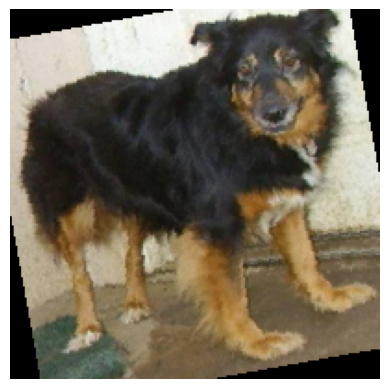

In [39]:
image = train_dataset.__getitem__(15)[0]
plt.axis('off')
plt.imshow(image.permute(1, 2, 0).cpu().numpy());

In [22]:
# Try compute with GPU if available, else CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [30]:
from torchvision.models import ResNet18_Weights, resnet18

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    epoch_loss_val = 0
    epoch_acc_val = 0

    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_batch.to(DEVICE))

        loss = loss_fn(outputs, torch.nn.functional.one_hot(y_batch.to(DEVICE), 2).float())
        loss.backward()
        optimizer.step()

        acc = ((outputs.argmax(dim=1) == y_batch.to(DEVICE)).float().mean())
        epoch_acc += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)

    print(f'Epoch {epoch + 1}: train_loss = {epoch_loss}, train_acc = {epoch_acc}')


    for iteration, (X_batch, y_batch) in enumerate(val_loader):
        model.eval()

        with torch.no_grad():
            outputs = model(X_batch.to(DEVICE))
            loss = loss_fn(outputs, torch.nn.functional.one_hot(y_batch.to(DEVICE), 2).float())


        # calculate accuracy & loss
        acc = ((outputs.argmax(dim=1) == y_batch.to(DEVICE)).float().mean())
        epoch_acc_val += acc/len(val_loader)
        epoch_loss_val += loss/len(val_loader)

    print(f'Epoch {epoch + 1}: val_loss = {epoch_loss_val}, val_acc = {epoch_acc_val}')

Epoch 1: train_loss = 0.25191599130630493, train_acc = 0.89570152759552
Epoch 1: val_loss = 0.19328856468200684, val_acc = 0.9217228293418884
Epoch 2: train_loss = 0.1749403178691864, train_acc = 0.9306545853614807
Epoch 2: val_loss = 0.1523675173521042, val_acc = 0.9382960200309753
Epoch 3: train_loss = 0.1623225063085556, train_acc = 0.9345046281814575
Epoch 3: val_loss = 0.12178999185562134, val_acc = 0.946882426738739
Epoch 4: train_loss = 0.1387994885444641, train_acc = 0.9434555768966675
Epoch 4: val_loss = 0.15417887270450592, val_acc = 0.92931067943573
Epoch 5: train_loss = 0.12527357041835785, train_acc = 0.9504066705703735
Epoch 5: val_loss = 0.1112486869096756, val_acc = 0.9532721638679504
Epoch 6: train_loss = 0.10875225067138672, train_acc = 0.9551069140434265
Epoch 6: val_loss = 0.10223294794559479, val_acc = 0.9548695683479309
Epoch 7: train_loss = 0.10185948759317398, train_acc = 0.959657609462738
Epoch 7: val_loss = 0.1395229995250702, val_acc = 0.9392946362495422
Epoc

In [31]:
import torch
import torch.nn as nn
from torchvision.models import SqueezeNet

model = SqueezeNet(version="1_0")

model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = 2

model = model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    epoch_loss_val = 0
    epoch_acc_val = 0

    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_batch.to(DEVICE))

        loss = loss_fn(outputs, torch.nn.functional.one_hot(y_batch.to(DEVICE), 2).float())
        loss.backward()
        optimizer.step()

        acc = ((outputs.argmax(dim=1) == y_batch.to(DEVICE)).float().mean())
        epoch_acc += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)

    print(f'Epoch {epoch + 1}: train_loss = {epoch_loss}, train_acc = {epoch_acc}')


    for iteration, (X_batch, y_batch) in enumerate(val_loader):
        model.eval()

        with torch.no_grad():
            outputs = model(X_batch.to(DEVICE))
            loss = loss_fn(outputs, torch.nn.functional.one_hot(y_batch.to(DEVICE), 2).float())


        # calculate accuracy & loss
        acc = ((outputs.argmax(dim=1) == y_batch.to(DEVICE)).float().mean())
        epoch_acc_val += acc/len(val_loader)
        epoch_loss_val += loss/len(val_loader)

    print(f'Epoch {epoch + 1}: val_loss = {epoch_loss_val}, val_acc = {epoch_acc_val}')

Epoch 1: train_loss = 0.6936254501342773, train_acc = 0.5014986395835876
Epoch 1: val_loss = 0.693148136138916, val_acc = 0.499200701713562
Epoch 2: train_loss = 0.6931477189064026, train_acc = 0.5000982880592346
Epoch 2: val_loss = 0.693148136138916, val_acc = 0.4996001124382019
Epoch 3: train_loss = 0.6931477189064026, train_acc = 0.500148355960846
Epoch 3: val_loss = 0.693148136138916, val_acc = 0.49979984760284424
Epoch 4: train_loss = 0.6931477189064026, train_acc = 0.500098466873169
Epoch 4: val_loss = 0.693148136138916, val_acc = 0.49920082092285156
Epoch 5: train_loss = 0.6931477189064026, train_acc = 0.5001487135887146
Epoch 5: val_loss = 0.693148136138916, val_acc = 0.49940064549446106
Epoch 6: train_loss = 0.6931477189064026, train_acc = 0.5001486539840698
Epoch 6: val_loss = 0.693148136138916, val_acc = 0.49940061569213867
Epoch 7: train_loss = 0.6931477189064026, train_acc = 0.500148355960846
Epoch 7: val_loss = 0.693148136138916, val_acc = 0.49960020184516907
Epoch 8: tra

In [33]:
import torch
import torch.nn as nn
from torchvision.models import alexnet

model = alexnet(pretrained=True)

model.classifier[6] = nn.Linear(4096, 2)

model = model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 141MB/s]


In [34]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    epoch_loss_val = 0
    epoch_acc_val = 0

    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_batch.to(DEVICE))

        loss = loss_fn(outputs, torch.nn.functional.one_hot(y_batch.to(DEVICE), 2).float())
        loss.backward()
        optimizer.step()

        acc = ((outputs.argmax(dim=1) == y_batch.to(DEVICE)).float().mean())
        epoch_acc += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)

    print(f'Epoch {epoch + 1}: train_loss = {epoch_loss}, train_acc = {epoch_acc}')


    for iteration, (X_batch, y_batch) in enumerate(val_loader):
        model.eval()

        with torch.no_grad():
            outputs = model(X_batch.to(DEVICE))
            loss = loss_fn(outputs, torch.nn.functional.one_hot(y_batch.to(DEVICE), 2).float())


        # calculate accuracy & loss
        acc = ((outputs.argmax(dim=1) == y_batch.to(DEVICE)).float().mean())
        epoch_acc_val += acc/len(val_loader)
        epoch_loss_val += loss/len(val_loader)

    print(f'Epoch {epoch + 1}: val_loss = {epoch_loss_val}, val_acc = {epoch_acc_val}')

Epoch 1: train_loss = 0.7015253901481628, train_acc = 0.5005984902381897
Epoch 1: val_loss = 0.6931489706039429, val_acc = 0.49960002303123474
Epoch 2: train_loss = 0.693725049495697, train_acc = 0.4990983009338379
Epoch 2: val_loss = 0.6939380168914795, val_acc = 0.4992009401321411
Epoch 3: train_loss = 0.6937926411628723, train_acc = 0.49349838495254517
Epoch 3: val_loss = 0.693153440952301, val_acc = 0.4994003176689148
Epoch 4: train_loss = 0.6935552954673767, train_acc = 0.4938487112522125
Epoch 4: val_loss = 0.6932127475738525, val_acc = 0.5003988742828369
Epoch 5: train_loss = 0.6933445930480957, train_acc = 0.508948802947998
Epoch 5: val_loss = 0.6957614421844482, val_acc = 0.4986018240451813
Epoch 6: train_loss = 0.6936100721359253, train_acc = 0.5035486221313477
Epoch 6: val_loss = 0.6931625008583069, val_acc = 0.500798225402832
Epoch 7: train_loss = 0.6939241290092468, train_acc = 0.4971987307071686
Epoch 7: val_loss = 0.6934058666229248, val_acc = 0.5005983114242554
Epoch 8:

In [36]:
results = {
    'resnet18' : [0.9217228293418884, 0.9382960200309753, 0.946882426738739, 0.92931067943573, 0.9532721638679504,
            0.9548695683479309, 0.9392946362495422, 0.9614591002464294, 0.9624574780464172, 0.9606602787971497],
    'SqueezeNet': [0.499200701713562, 0.4996001124382019, 0.49979984760284424, 0.49920082092285156, 0.49940064549446106,
            0.49940061569213867, 0.49960020184516907, 0.4990011155605316, 0.49960023164749146, 0.4996003806591034],
    'alexnet' : [0.49960002303123474, 0.4992009401321411, 0.4994003176689148, 0.5003988742828369, 0.4986018240451813,
           0.500798225402832, 0.5005983114242554, 0.4994005858898163, 0.4988013803958893, 0.5003988146781921]
}

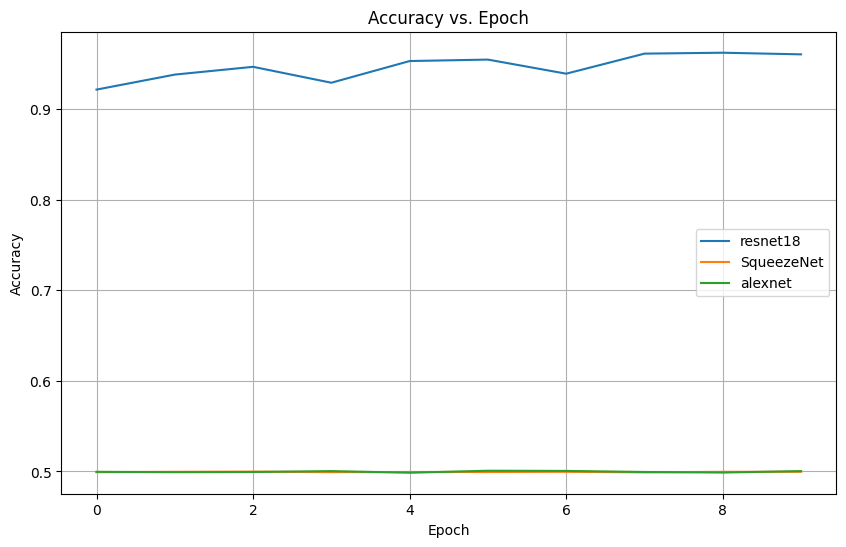

In [38]:
labels = list(results.keys())
values = list(results.values())

plt.figure(figsize=(10, 6))
for label, value in zip(labels, values):
    plt.plot(value, label=str(label))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend(loc='best')
plt.grid(True)

plt.show()